In [1]:
import matplotlib.pyplot as plt
import numpy as np

import gpflow
import pandas as pd
import os
import matplotlib.pyplot as plt
import re
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn import preprocessing
from xgboost import XGBRegressor

2024-06-14 14:51:47.856367: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-14 14:51:50.578173: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /share/apps/22.04/openmpi/4.1.5/lib:/share/apps/22.04/slurm/23.02.7/lib
2024-06-14 14:51:50.578205: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-06-14 14:51:50.792639: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has al

In [2]:
pfts = ["Tropical", "Temperate_Broadleaf","Temperate_Deciduous"
        ,"Temperate_Coniferous","Boreal"]

In [3]:
####read in 
pft = pfts[3]

temperate_coniferous_model_data = pd.concat([
  pd.read_csv('/home/smmrrr/TEM_Analysis/TEM_Analysis/' + pft + '_trainingset_r_1_9.csv')
  , pd.read_csv('/home/smmrrr/TEM_Analysis/TEM_Analysis/' + pft + '_trainingset_r_10_19.csv')
  , pd.read_csv('/home/smmrrr/TEM_Analysis/TEM_Analysis/' + pft + '_trainingset_r_20_29.csv')
])



In [7]:
future_model_data = pd.read_csv('/home/smmrrr/TEM_Analysis/TEM_Analysis/whole_time_ssp245_'+pft+'_trainingset_r_1_29.csv')


In [8]:
temperate_coniferous_model_data.columns

future_model_data.columns

Index(['lon', 'lat', 'year', 'stand_age_interval_min', 'current_veg',
       'community_type', 'silt_clay', ' AVAILN ', ' GPP ', ' LAI ', ' NCE ',
       ' NEP ', ' NETNMIN ', ' NPP ', ' SOILORGC ', ' VEGC ', ' VEGINNPP ',
       ' VSM ', 'region', 'ordinal_stand_age'],
      dtype='object')

In [9]:
temperate_coniferous_model_data = temperate_coniferous_model_data[['lon', 'lat', 'year', 'stand_age_interval_min','ordinal_stand_age'
                                                                   , 'current_veg','community_type', 'silt_clay'
                                                                  ,' GPP ', ' NPP ', ' SOILORGC ', ' VEGC ']]

future_model_data = future_model_data[['lon', 'lat', 'year', 'stand_age_interval_min','ordinal_stand_age'
                                                                   , 'current_veg','community_type', 'silt_clay'
                                                                  ,' GPP ', ' NPP ', ' SOILORGC ', ' VEGC ']]

In [11]:
input_data = pd.read_csv('/home/smmrrr/TEM_Analysis/TEM_Analysis/global_input_vars.csv')
future_input_data = pd.read_csv('/home/smmrrr/TEM_Analysis/TEM_Analysis/whole_time_CanESM5xx1_ssp245_global_input_vars.csv')
future_input_data = future_input_data.loc[future_input_data['year'] >= 2014 ]

In [12]:

temperate_coniferous_model_data = pd.merge(temperate_coniferous_model_data, input_data, on = ['lon','lat','year'])


In [14]:
print(len(future_model_data))
future_model_data = pd.merge(future_model_data, future_input_data, on = ['lon','lat','year'])
print(len(future_model_data))


4003609
4003609


In [19]:
temperate_coniferous_model_data.loc[temperate_coniferous_model_data['tmp_min']< -30, ['tmp_min', ' GPP ', ' NPP ', ' SOILORGC ', ' VEGC ']].describe()

,tmp_min,GPP,NPP,SOILORGC,VEGC
count,9778.000000,9778.000000,9778.000000,9778.000000,9778.000000
mean,-32.691900,20.857912,12.315714,3869.672722,989.206262
std,2.255919,19.242821,11.374210,1587.200134,1099.790989
min,-40.000000,0.060000,-2.790000,327.530000,0.040000
25%,-34.200000,4.480000,2.772500,2459.415000,166.615000
50%,-32.000000,16.350000,9.970000,3968.680000,597.840000
75%,-30.800000,31.327500,18.425000,5181.342500,1516.542500
max,-30.100000,113.740000,72.880000,9319.280000,7644.000000


In [20]:
print(len(temperate_coniferous_model_data))


5364643


In [21]:
del future_input_data, input_data

In [22]:
temperate_coniferous_model_data = temperate_coniferous_model_data.loc[temperate_coniferous_model_data['year']>=1900]
# model_data = model_data.loc[model_data['monthly_mean_ratio']<=3]

In [23]:
temperate_coniferous_model_data.columns

Index(['lon', 'lat', 'year', 'stand_age_interval_min', 'ordinal_stand_age',
       'current_veg', 'community_type', 'silt_clay', ' GPP ', ' NPP ',
       ' SOILORGC ', ' VEGC ', 'tswrf_v11_avg', 'tswrf_v11_min',
       'tswrf_v11_max', 'tmp_avg', 'tmp_min', 'tmp_max', 'precip_avg',
       'precip_min', 'precip_max', 'dtr_avg', 'dtr_min', 'dtr_max', 'vpr_avg',
       'vpr_min', 'vpr_max', 'wind_avg', 'wind_min', 'wind_max', 'Ndep_Trendy',
       'Nfer_crop', 'Nfer_pas', 'var_x', 'Area', 's1', 's2', 's3', 'tt',
       'soil_text', 'region', 'var_y', 'elev', 'co2'],
      dtype='object')

In [25]:
temperate_coniferous_model_data.loc[temperate_coniferous_model_data[' SOILORGC '] > 15000, [' GPP ', ' NPP ', ' SOILORGC ', ' VEGC ']]

,GPP,NPP,SOILORGC,VEGC
1703261,80.54,37.56,15245.70,858.30
1849202,92.03,42.03,18853.04,1052.13
1849204,66.27,34.44,17191.29,1247.20
1891725,67.07,30.27,19768.28,855.83
1891737,66.39,39.54,18296.96,996.72
...,...,...,...,...
4534782,63.99,30.68,20167.96,1604.69
4822157,116.03,57.79,15197.00,1220.62
4827313,113.25,51.81,15746.78,1241.87
5343312,125.83,67.60,17274.17,1226.39


In [24]:
future_model_data.loc[future_model_data[' SOILORGC '] > 15000, [' GPP ', ' NPP ', ' SOILORGC ', ' VEGC ']]

,GPP,NPP,SOILORGC,VEGC
1824344,75.55,38.15,35973.85,953.11
1824362,99.31,49.12,31765.82,1204.87
1824380,199.90,119.37,24279.27,1872.52
1824398,239.85,131.58,18827.08,2888.22
1953214,232.70,126.96,15021.38,1881.30
...,...,...,...,...
3826277,163.32,88.46,15220.03,1567.45
3826346,162.52,88.67,15139.44,1568.08
3826397,166.90,93.15,19754.30,1651.40
3826408,182.89,111.91,17903.35,2377.91


In [26]:
temperate_coniferous_model_data[[' GPP ', ' NPP ', ' SOILORGC ', ' VEGC ']].describe()

,GPP,NPP,SOILORGC,VEGC
count,5.364643e+06,5.364643e+06,5.364643e+06,5.364643e+06
mean,5.933493e+01,3.011057e+01,3.292819e+03,4.106630e+03
std,5.149477e+01,2.660748e+01,2.229278e+03,4.506305e+03
min,0.000000e+00,-3.449000e+01,0.000000e+00,0.000000e+00
25%,1.410000e+01,6.600000e+00,1.385050e+03,6.663300e+02
50%,4.833000e+01,2.482000e+01,3.069350e+03,2.628370e+03
75%,9.222000e+01,4.685000e+01,4.960810e+03,5.961660e+03
max,3.424400e+02,1.707700e+02,8.217287e+04,3.418184e+04


In [27]:
future_model_data[[' GPP ', ' NPP ', ' SOILORGC ', ' VEGC ']].describe()

,GPP,NPP,SOILORGC,VEGC
count,4.003609e+06,4.003609e+06,4.003609e+06,4.003609e+06
mean,6.651161e+01,3.310790e+01,2.967023e+03,4.455040e+03
std,5.314009e+01,2.824672e+01,2.074173e+03,4.429519e+03
min,0.000000e+00,-5.460000e+01,0.000000e+00,0.000000e+00
25%,2.017000e+01,9.300000e+00,1.323680e+03,1.026940e+03
50%,5.754000e+01,2.769000e+01,2.527280e+03,3.227640e+03
75%,1.013300e+02,5.101000e+01,4.390300e+03,6.511100e+03
max,3.776600e+02,2.161200e+02,8.256628e+04,4.318731e+04


<Axes: >

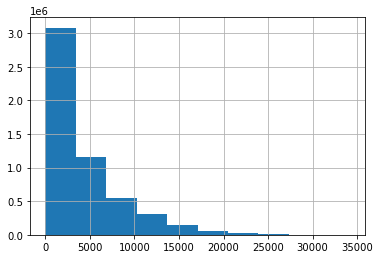

In [30]:
temperate_coniferous_model_data[' VEGC '].hist()

<Axes: >

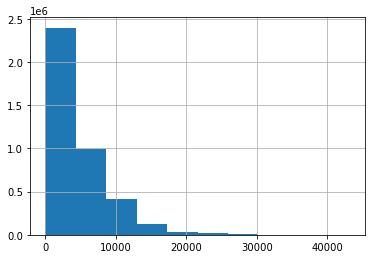

In [32]:
future_model_data[' VEGC '].hist()

<Axes: >

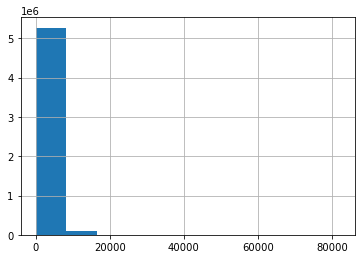

In [31]:
temperate_coniferous_model_data[' SOILORGC '].hist()

In [10]:
###drop relevant ranges from all pfts

temperate_coniferous_model_data=temperate_coniferous_model_data.loc[temperate_coniferous_model_data[' SOILORGC '] < 15000]

In [ ]:
#### create a training set for historical, future, and all time

In [11]:
# Define the features and target variable
X = np.array(temperate_coniferous_model_data[['ordinal_stand_age'
                         , 'tswrf_v11_avg', 'tswrf_v11_min',
       'tswrf_v11_max', 'tmp_avg', 'tmp_min', 'tmp_max', 'precip_avg',
       'precip_min', 'precip_max', 'dtr_avg', 'dtr_min', 'dtr_max', 'vpr_avg',
       'vpr_min', 'vpr_max', 'wind_avg', 'wind_min', 'wind_max','s1', 's2', 'co2']])
Y = np.array(temperate_coniferous_model_data[[' GPP ', ' NPP ', ' SOILORGC ', ' VEGC ']])

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
Y = Y.reshape(len(Y),1)


In [12]:
X_test.shape

(1038606, 22)

In [16]:
# Initialize XGBRegressor (you can specify hyperparameters as needed)
# for depth in range(12, 20):
#     for lr in [.1,.3]:
depth = 12
lr = .1
xgb_model = XGBRegressor(max_depth=depth,learning_rate=lr)

# Fit the model on the scaled data
xgb_model.fit(X_train, Y_train)

# Make predictions (as an example, here we predict on the training data itself)
# predictions = xgb_model.predict(X_scaled)
print(f"training {depth} {lr}: ",xgb_model.score(X_train, Y_train) )
print(f"testing {depth} {lr}: ",xgb_model.score(X_test, Y_test) )

training 12 0.1:  0.9428729022357923
testing 12 0.1:  0.9284650036206079


In [ ]:
# for i in range(5, 20):

i = 18
regr = RandomForestRegressor(max_depth=i, random_state=0)
regr.fit(X_train, Y_train)
print(f"training {i}: ",regr.score(X_train, Y_train) )
print(f"testing {i}: ",regr.score(X_test, Y_test) )

/tmp/ipykernel_155618/2726865445.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regr.fit(X_train, Y_train)


In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout


In [55]:

# Example model architecture
model = Sequential()
# Input layer and first hidden layer
model.add(Dense(128, input_dim=22, activation='relu'))  # First hidden layer with 128 neurons
model.add(Dropout(0.3))                                 # Dropout layer to reduce overfitting (30% dropout)

# Second hidden layer
model.add(Dense(64, activation='relu'))                 # Second hidden layer with 64 neurons
model.add(Dropout(0.3))                                 # Another dropout layer

# Third hidden layer
model.add(Dense(32, activation='relu'))                 # Third hidden layer with 32 neurons

# Output layer for regression
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Summary of the model
model.summary()

# Assuming you have your data in variables X (features) and y (target)
# Fit the model
model.fit(X_train, Y_train, epochs=50, batch_size=1024, validation_split=0.2, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               2944      
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 13,313
Trainable params: 13,313
Non-trai

In [56]:
Y_test=Y_test.reshape(len(Y_test),1)
# Step 1: Predict on the validation set
y_pred = model.predict(X_test)

# Step 2: Calculate R²
r2 = r2_score(Y_test, y_pred)
print(f'R²: {r2}')

# Step 3: Calculate RMSE
rmse = np.sqrt(np.mean((y_pred - Y_test) ** 2))
print(f'RMSE: {rmse}')

97370/97370 [==============================] - 73s 749us/step
R²: 0.7769180850443543
RMSE: 2152.76862554213


In [23]:
y_pred.shape

(1038606, 1)

In [24]:
Y_test.shape

(1038606,)

In [71]:
# rng = np.random.default_rng(1234)
# n_inducing = 500
# inducing_variable = rng.choice(X, size=n_inducing, replace=False)


In [34]:
6*40

240

In [29]:
# Define the features and target variable
X = np.array(temperate_coniferous_model_data[['ordinal_stand_age'
                         , 'tswrf_v11_avg', 'tswrf_v11_min',
       'tswrf_v11_max', 'tmp_avg', 'tmp_min', 'tmp_max', 'precip_avg',
       'precip_min', 'precip_max', 'dtr_avg', 'dtr_min', 'dtr_max', 'vpr_avg',
       'vpr_min', 'vpr_max', 'wind_avg', 'wind_min', 'wind_max','s1', 's2', 'co2']])
Y = np.array(temperate_coniferous_model_data[' VEGC '])

# Split the data into training and testing sets (80% train, 20% test)
# randomness can be controlled with a defined `random_state`
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.9, random_state=42)
# Y = np.array(
#     model_data.loc[:, 'monthly_mean_ratio']
# )
# X = np.array(
#      # model_data.loc[model_data['year']>=2020,['ordinal_stand_age']]
#      model_data.loc[:,['ordinal_stand_age','tmp_ratio']]
# )
Y = Y.reshape(len(Y),1)


In [30]:
Y_train.shape

(346201,)

In [31]:
rng = np.random.default_rng(12345)
bin_size = 40
# Calculate the percentile values on Y
percentiles = [0, 10, 25, 50, 75, 90, 100]
percentile_values = np.percentile(Y_train, percentiles)
print(percentile_values)
# Initialize a list to store the indices of the subsets
subset_indices = np.array([])
# subset_indices= subset_indices.reshape((0, 1))
# For each pair of percentile values, select the indices of 100 points from within that range
for i in range(len(percentile_values) - 1):
    # Get the value range for the current bin
    low, high = percentile_values[i], percentile_values[i+1]
    
    # Find the indices where Y falls within the current percentile range 
    # Assuming Y is 1D and has the same length as the rows or columns of X
    in_range_indices = np.array(np.where((Y_train >= low) & (Y_train < high)))
    print(in_range_indices)
    in_range_indices=in_range_indices.reshape(in_range_indices.shape[1],1)
    # Randomly select up to 100 indices within this range
    # Here we are careful to only take as many indices as are available if there are fewer than 100
    selected_indices = rng.choice(in_range_indices, size= bin_size, replace=False)
    # selected_indices=selected_indices.reshape()
    # Extend the subset_indices list with the selected indices
    if (i==0):
        subset_indices=selected_indices
    else:
        subset_indices=np.vstack([subset_indices,selected_indices])
# subset_indices.shape
# Using the selected indices, we can now reference the corresponding rows from X
inducing_variable = X_train[subset_indices.flatten(),:]

[    0.      93.99   651.31  2520.79  5808.63 10741.31 33846.79]
[[     0      6     32 ... 346141 346143 346199]]
[[     1      3     11 ... 346190 346194 346200]]
[[     2     18     19 ... 346192 346197 346198]]
[[     5      8     10 ... 346181 346185 346189]]
[[     9     16     34 ... 346193 346195 346196]]
[[     4      7     12 ... 346152 346166 346187]]


In [32]:
# inducing_variable
Y_train = Y_train.reshape(len(Y_train),1)
Y_test = Y_test.reshape(len(Y_test),1)

In [33]:
model = gpflow.models.SGPR(
    (X_train, Y_train),
    kernel=gpflow.kernels.RBF(),
    # kernel=gpflow.kernels.SquaredExponential(),
    inducing_variable=inducing_variable,
        # noise_variance=1.0  # Set to some reasonable initial value
)

In [34]:
print(gpflow.utilities.print_summary(model, "notebook"))

name,class,transform,prior,trainable,shape,dtype,value
SGPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
SGPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.0
SGPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0
SGPR.inducing_variable.Z,Parameter,Identity,,True,"(240, 22)",float64,"[[0., 134.53, 23.52..."


None


In [35]:
import tensorflow as tf

start_time = time.time()
# Instantiate an Adam optimizer with a set learning rate
adam_optimizer = tf.optimizers.Adam(learning_rate=0.1)

# Run the optimization loop
# Perform a number of optimization steps
num_iterations = 1000  # Choose an appropriate number of iterations for your problem
for i in range(num_iterations):
    adam_optimizer.minimize(model.training_loss, model.trainable_variables)
    if (i % 100 ==0):
        print(i)
        elapsed_time_minutes = (time.time() - start_time) / 60
        print(f"Elapsed time: {elapsed_time_minutes:.2f} minutes")

0
Elapsed time: 0.32 minutes


KeyboardInterrupt: 

In [36]:
X_train.shape[1]

22

In [37]:
i

28

In [32]:
print(gpflow.utilities.print_summary(model, "notebook"))
###save model
model.compiled_predict_f = tf.function(
    lambda Xnew: model.predict_f(Xnew, full_cov=False),
    input_signature=[tf.TensorSpec(shape=[None, X_train.shape[1]], dtype=tf.float64)],
)
model.compiled_predict_y = tf.function(
    lambda Xnew: model.predict_y(Xnew, full_cov=False),
    input_signature=[tf.TensorSpec(shape=[None, X_train.shape[1]], dtype=tf.float64)],
)

save_dir = "/home/smmrrr/TEM_Analysis/TEM_Analysis/models/"
save_name = "test_gp"
tf.saved_model.save(model, save_dir+save_name)


name,class,transform,prior,trainable,shape,dtype,value
SGPR.kernel.variance,Parameter,Softplus,,True,(),float64,10.20754
SGPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,12.64812
SGPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,7.36865
SGPR.inducing_variable.Z,Parameter,Identity,,True,"(72, 8)",float64,"[[-2.38590000e+00, -8.24101000e+00, -4.74807000e+00..."


None
INFO:tensorflow:Assets written to: /home/smmrrr/TEM_Analysis/TEM_Analysis/models/test_gp/assets


In [28]:
# loaded_model = tf.saved_model.load( save_dir+save_name)

In [38]:
mean, var =  model.predict_y(
X_test
)

Y_pred = mean.numpy().flatten()
# Y_test = np.array(model_data.loc[model_data['year'].between(1950,2020),'monthly_mean_ratio'])

# Calculate the sum of squares of residuals
# SS_res = np.sum((Y_test - Y_pred) ** 2)

# # Calculate the total sum of squares
# SS_tot = np.sum((Y_test - np.mean(Y_test)) ** 2)
# rmse = np.sqrt(SS_res/len(Y_test))
# # Calculate the R² score
# r2_score = 1 - (SS_res / SS_tot)
# print("Test RMSE: ",rmse)
# print("Test R2: ",r2_score)



MemoryError: Unable to allocate 70.6 TiB for an array with shape (3115816, 3115816) and data type float64

In [43]:
X_test.shape

(3115816, 22)

In [49]:
mean, var =  model.predict_y(
X_test
)


In [50]:
mean=np.array(mean)

In [53]:
mean.mean()

1.2684391502320138

In [54]:
Y_test.mean()

4065.522745486254

In [51]:
# Step 2: Calculate R²
r2 = r2_score(Y_test, mean)
print(f'R²: {r2}')

# # Step 3: Calculate RMSE
# rmse = np.sqrt(np.mean((y_pred - Y_test) ** 2))
# print(f'RMSE: {rmse}')

R²: -0.7948079932275038


In [20]:
mean, var = model.predict_y(
#     np.array(
#      model_data.loc[model_data['year'].between(1950,2020),[['tmp_ratio', 'co2_ratio', 'ordinal_stand_age']]]
# )
X_train
)

Y_pred = mean.numpy().flatten()
# Y_test = np.array(model_data.loc[model_data['year'].between(1950,2020),'monthly_mean_ratio'])

# Calculate the sum of squares of residuals
SS_res = np.sum((Y_train - Y_pred) ** 2)

# Calculate the total sum of squares
SS_tot = np.sum((Y_train - np.mean(Y_train)) ** 2)
rmse = np.sqrt(SS_res/len(Y_test))
# Calculate the R² score
r2_score = 1 - (SS_res / SS_tot)
print("Train RMSE: ",rmse)
print("Train R2: ",r2_score)



Train RMSE:  2753.2375472308922
Train R2:  0.06238171334554565
